In [1]:
from keras.losses import SparseCategoricalCrossentropy
import zipfile
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.layers import (Permute,Rescaling,Reshape,Resizing,InputLayer,MaxPool2D,AveragePooling2D,GlobalAveragePooling2D,Conv2D,
                                     Flatten,Dropout,BatchNormalization,Dense)
from tensorflow.keras.regularizers import L2,L1
from tensorflow.keras.metrics import (Accuracy,SparseCategoricalAccuracy,CategoricalAccuracy,TopKCategoricalAccuracy)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

files.upload() #this will prompt you to upload the

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aksh2704","key":"6775788223fc875ad4415ea43b797876"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Jun  1 14:55 kaggle.json


In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 305M/309M [00:03<00:00, 128MB/s]
100% 309M/309M [00:03<00:00, 94.9MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

In [9]:
train_datapath="/content/dataset/Emotions Dataset/Emotions Dataset/train/"
val_datapath="/content/dataset/Emotions Dataset/Emotions Dataset/test/"
CLASS_NAME=["angry","happy","sad"]

In [10]:
CONFIGURATION={
    "BATCH_SIZE":32,
    "IMG_SIZE":256,
    "CLASS_NAMES": ["angry", "happy", "sad"],
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0,
    "N_FILTERS": 16,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,

}

##**Dataset Loading**

In [11]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    directory=train_datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [12]:
val_dataset=tf.keras.utils.image_dataset_from_directory(
    directory=val_datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


##**Dataset Preperation**

In [13]:
training_dataset=(
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
val_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [15]:
training_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [16]:
print(len(train_dataset))

213


In [17]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
print(len(val_dataset))

72


In [19]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
       Rescaling(1./255),                 
])

##**Dataset Visualization**

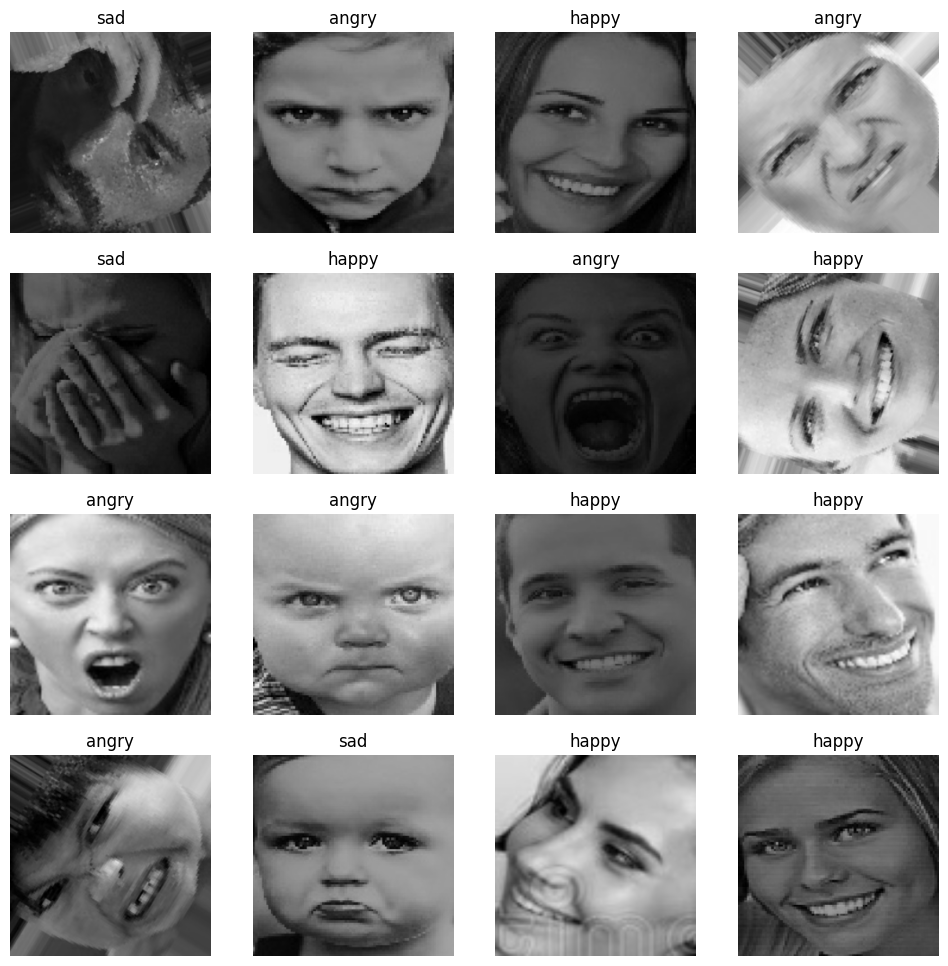

In [20]:
plt.figure(figsize=(12,12))

for image,labels in train_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(CONFIGURATION['CLASS_NAMES'][tf.argmax(labels[i],axis=-1).numpy()])
    plt.axis("off")

In [21]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 36)     

In [22]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [23]:
lenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"]),
                    metrics=["accuracy"])

In [24]:
for name,label in training_dataset.take(1):
  print(len(label.shape))

2


In [25]:
history_1=lenet_model.fit(training_dataset,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1)

Epoch 1/10
213/213 [==============================] - 41s 104ms/step - loss: 8.7393 - accuracy: 0.4895 - val_loss: 8.0139 - val_accuracy: 0.2853
Epoch 2/10
213/213 [==============================] - 22s 100ms/step - loss: 0.9021 - accuracy: 0.5763 - val_loss: 1.8945 - val_accuracy: 0.4811
Epoch 3/10
213/213 [==============================] - 22s 102ms/step - loss: 0.7268 - accuracy: 0.6623 - val_loss: 0.9052 - val_accuracy: 0.6563
Epoch 4/10
213/213 [==============================] - 23s 105ms/step - loss: 0.6089 - accuracy: 0.7254 - val_loss: 0.8947 - val_accuracy: 0.6225
Epoch 5/10
213/213 [==============================] - 23s 106ms/step - loss: 0.4792 - accuracy: 0.7891 - val_loss: 1.1492 - val_accuracy: 0.6462
Epoch 6/10
213/213 [==============================] - 22s 100ms/step - loss: 0.3895 - accuracy: 0.8222 - val_loss: 1.1433 - val_accuracy: 0.6725
Epoch 7/10
213/213 [==============================] - 26s 119ms/step - loss: 0.3439 - accuracy: 0.8519 - val_loss: 1.2034 - val_ac

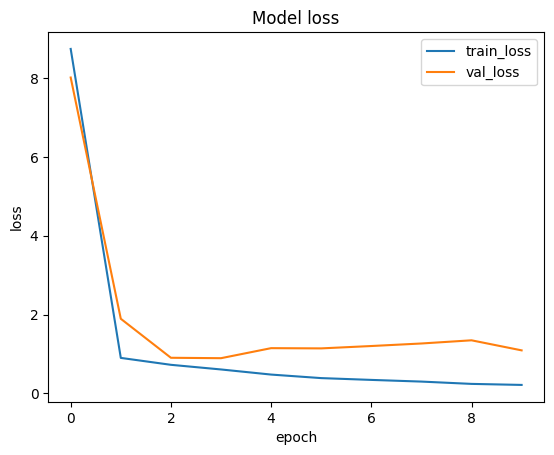

In [26]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

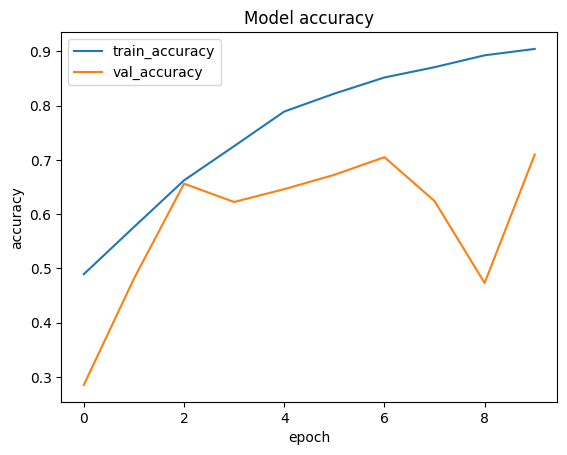

In [27]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Patch Encoder

In [28]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/178238.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IMG_SIZE"] ,CONFIGURATION["IMG_SIZE"]))

In [29]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [30]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


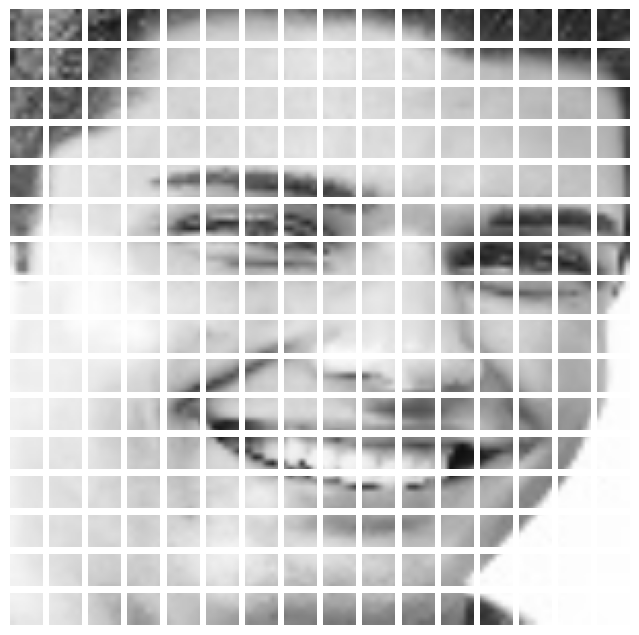

In [31]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

In [32]:
class PatchEncoder(tf.keras.layers.Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding =tf.keras.layers.Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')
    
    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))
    
    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
    
    return output

### TransformerEncoder

In [33]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = tf.keras.layers.LayerNormalization()
    self.layer_norm_2 = tf.keras.layers.LayerNormalization()
    
    self.multi_head_att = tf.keras.layers.MultiHeadAttention(N_HEADS, HIDDEN_SIZE )
    
    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    
  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = tf.keras.layers.Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = tf.keras.layers.Add()([output, x_1])

    return output

### ViT Model

In [34]:
class ViT(tf.keras.Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)
    
    return self.dense_3(x)

In [35]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.24539897, 0.4859455 , 0.26865557],
       [0.24539897, 0.4859455 , 0.26865557]], dtype=float32)>

In [36]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncoder  multiple                 787200    
 )                                                               
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 dense_8 (Dense)             multiple                  25165952  
                                                                 
 dense_9 (Dense)             multiple                  16512     
                                                

In [37]:
vit.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"]),
                    metrics=["accuracy"])

In [38]:
history_2=vit.fit(training_dataset,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1)

Epoch 1/10
213/213 [==============================] - 114s 485ms/step - loss: 1184.8064 - accuracy: 0.4230 - val_loss: 57.9573 - val_accuracy: 0.4197
Epoch 2/10
213/213 [==============================] - 93s 436ms/step - loss: 31.9193 - accuracy: 0.5589 - val_loss: 38.5567 - val_accuracy: 0.5439
Epoch 3/10
213/213 [==============================] - 90s 422ms/step - loss: 1363.6205 - accuracy: 0.4021 - val_loss: 1.4639 - val_accuracy: 0.4416
Epoch 4/10
213/213 [==============================] - 87s 406ms/step - loss: 1.1933 - accuracy: 0.4459 - val_loss: 1.0623 - val_accuracy: 0.4429
Epoch 5/10
213/213 [==============================] - 87s 405ms/step - loss: 1.0782 - accuracy: 0.4454 - val_loss: 1.0627 - val_accuracy: 0.4421
Epoch 6/10
213/213 [==============================] - 97s 454ms/step - loss: 1.0673 - accuracy: 0.4449 - val_loss: 1.0627 - val_accuracy: 0.4421
Epoch 7/10
213/213 [==============================] - 87s 407ms/step - loss: 1.0653 - accuracy: 0.4446 - val_loss: 1.066

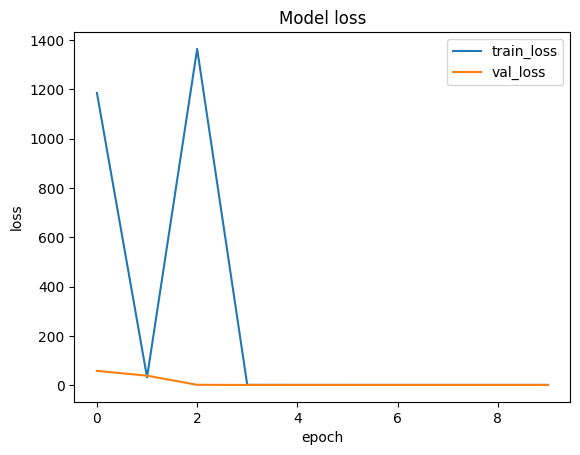

In [39]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

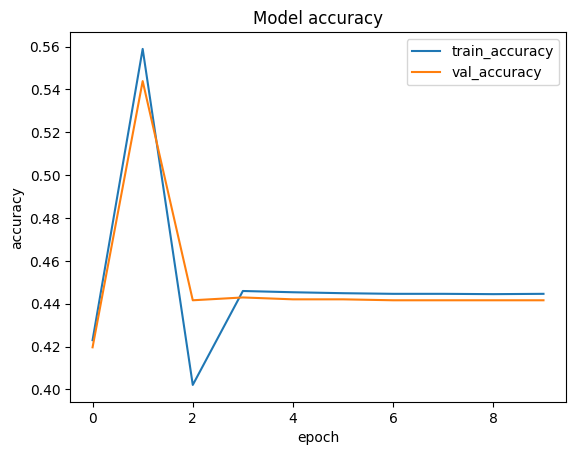

In [40]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

##**FineTuning With Pretrained Model(VIT Transformer)**

In [41]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.0 MB/s eta 0:00:00


### Training

In [42]:
resize_rescale_hf = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
       Permute((3,1,2))                
])

In [43]:
from transformers import ViTFeatureExtractor, TFViTModel


base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = tf.keras.layers.Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:]
#print(x)
output = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [44]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IMG_SIZE"] ,CONFIGURATION["IMG_SIZE"]))

In [45]:
hf_model(tf.expand_dims(test_image, axis = 0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.36348134, 0.19956471, 0.4369539 ]], dtype=float32)>

In [46]:
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0     

In [47]:
hf_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                    metrics=["accuracy"])

In [48]:
history_3=hf_model.fit(training_dataset,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1)

Epoch 1/10


213/213 [==============================] - 374s 1s/step - loss: 0.5021 - accuracy: 0.7914 - val_loss: 0.3481 - val_accuracy: 0.8652
Epoch 2/10
213/213 [==============================] - 292s 1s/step - loss: 0.2428 - accuracy: 0.9078 - val_loss: 0.3099 - val_accuracy: 0.8832
Epoch 3/10
213/213 [==============================] - 301s 1s/step - loss: 0.1552 - accuracy: 0.9429 - val_loss: 0.3686 - val_accuracy: 0.8635
Epoch 4/10
213/213 [==============================] - 293s 1s/step - loss: 0.1096 - accuracy: 0.9587 - val_loss: 0.3242 - val_accuracy: 0.8872
Epoch 5/10
213/213 [==============================] - 292s 1s/step - loss: 0.0903 - accuracy: 0.9648 - val_loss: 0.3398 - val_accuracy: 0.8854
Epoch 6/10
213/213 [==============================] - 292s 1s/step - loss: 0.0715 - accuracy: 0.9715 - val_loss: 0.3585 - val_accuracy: 0.8946
Epoch 7/10
213/213 [==============================] - 292s 1s/step - loss: 0.0735 - accuracy: 0.9698 - val_loss: 0.3996 - val_accuracy: 0.8907
Epoch 8/10

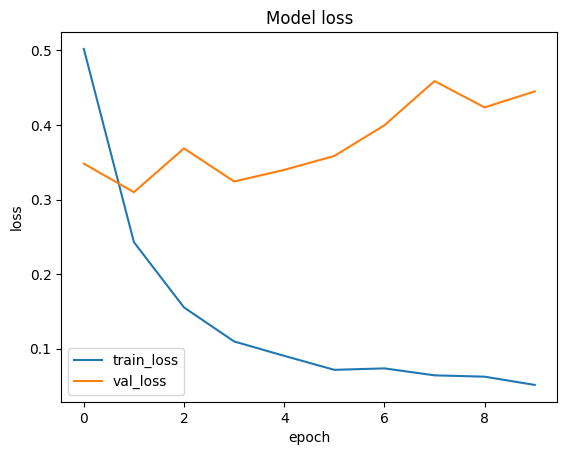

In [49]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

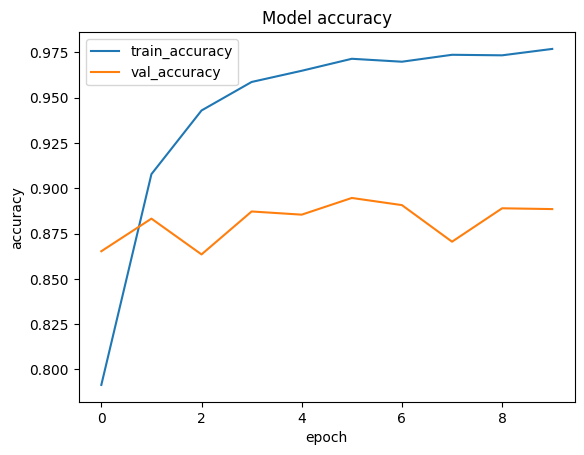

In [50]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()